In [1]:
import sys
sys.path.append("..")
import functools

import numpy as np
import jax.numpy as jnp
import jax
import scipy.linalg
import scipy.optimize
import matplotlib.pyplot as plt

import pyequion2
import tmcdiff.builder

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
eqsys = pyequion2.EquilibriumBackend(["Ca", "C", "Na", "Cl"], from_elements=True, backend="jax", logbase="e")

In [4]:
eqsys.nspecies

16

In [5]:
{sp: eqsys.get_standard_chemical_potentials(298.15)[i]/(8.314*298.15) for i, sp in enumerate(eqsys.species)}

{'H2O': DeviceArray(-95.6795, dtype=float32),
 'CO2': DeviceArray(-155.69572, dtype=float32),
 'CO3--': DeviceArray(-212.96431, dtype=float32),
 'Ca++': DeviceArray(-223.10623, dtype=float32),
 'CaCO3': DeviceArray(-443.49747, dtype=float32),
 'CaHCO3+': DeviceArray(-462.40097, dtype=float32),
 'CaOH+': DeviceArray(-289.35706, dtype=float32),
 'Cl-': DeviceArray(-52.952633, dtype=float32),
 'H+': DeviceArray(0., dtype=float32),
 'HCO3-': DeviceArray(-236.7487, dtype=float32),
 'Na+': DeviceArray(-105.651115, dtype=float32),
 'Na2CO3': DeviceArray(-425.81396, dtype=float32),
 'NaCO3-': DeviceArray(-321.5399, dtype=float32),
 'NaHCO3': DeviceArray(-341.82413, dtype=float32),
 'NaOH': DeviceArray(-168.67815, dtype=float32),
 'OH-': DeviceArray(-63.4536, dtype=float32)}

In [6]:
builder = tmcdiff.builder.TransportBuilder(eqsys,
                                           298.15,
                                           0.1,
                                           1e-6,
                                           jnp.array([1.0, 1.0, 1.0, 1.0, 0.0]), ["Calcite"])
builder.set_species(['CaCO3', 'CaHCO3+', 'CaOH+', 'Na2CO3', 'NaCO3-', 'NaHCO3', 'NaOH', 'CaOH+'])
builder.make_grid(60, 5)
builder.species
builder.simplified = True
builder.ideal_activity = True

In [7]:
builder.species

['CO2', 'CO3--', 'Ca++', 'Cl-', 'H+', 'HCO3-', 'Na+', 'OH-']

In [181]:
logc = np.ones([builder.nspecies, builder.ngrid])*0.0 - 0.0
mu = builder.reduced_standard_potentials[..., None] + logc
logcmu = jnp.vstack([logc, mu])
xinit = logcmu.flatten()
xinit2 = logc.flatten()

In [8]:
builder.flattened_equality_constraint

<bound method TransportBuilder.flattened_equality_constraint of <tmcdiff.builder.TransportBuilder object at 0x7feea432ac70>>

In [182]:
f = functools.partial(builder.flattened_minimization_objective, ftype=1)
df = functools.partial(builder.jac_flattened_minimization_objective, ftype=1)
g = functools.partial(builder.flattened_equality_constraint, ftype=1)
dg = functools.partial(builder.jac_flattened_equality_constraint, ftype=1)

In [183]:
g(xinit)

DeviceArray([19.52553  ,  0.       ,  0.       ,  0.       ,  0.       ,
              0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
              0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
              0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
              0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
              0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
              0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
              0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
              0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
              0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
              0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
              0.       ,  0.       ,  0.       ,  0.       ,  2.       ,
              0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
              0.       ,  0.       ,  0.       ,  0

In [184]:
equality_constraint = scipy.optimize.NonlinearConstraint(
    g,
    lb=0.0,
    ub=0.0,
    jac=dg)
bounds = scipy.optimize.Bounds(lb=-15.0, ub=5.0)
sol = scipy.optimize.minimize(f,
                              xinit,
                              constraints=equality_constraint,
                              method='trust-constr',
                              jac=df,
                              bounds=bounds,
                              options={'verbose':2})

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | -1.0505e+03 | 1.00e+00 | 2.88e+00 | 2.22e+02 |
|   2   |   2   |   1   | -1.0579e+03 | 7.00e+00 | 2.83e+00 | 2.22e+02 |


KeyboardInterrupt: 

In [163]:
logc = sol.x.reshape(builder.nspecies, builder.ngrid)

In [164]:
c = jnp.exp(logc)

Text(0.5, 0, '$y^+$')

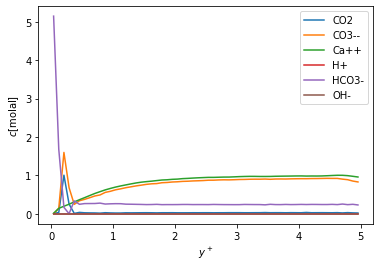

In [165]:
plt.figure()
for i in range(builder.nspecies):
    plt.plot(builder.ygrid, c[i, :], label=builder.species[i])
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')